In [1]:
%pip install numpy pandas matplotlib scikit-learn opencv-python

   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/7.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/7.8 MB 578.7 kB/s eta 0:00:13
   -- ------------------------------------- 0.5/7.8 MB 578.7 kB/s eta 0:00:13
   ---- ----------------------------------- 0.8/7.8 MB 599.2 kB/s eta 0:00:12
   ---- ----------------------------------- 0.8/7.8 MB 599.2 kB/s eta 0:00:12
   ----- ---------------------------------- 1.0/7.8 MB 621.2 kB/s eta 0:00:11
   ----- ---------------------------------- 1.0/7.8 MB 621.2 kB/s eta 0:00:11
   ------ --------------------------------- 1.3/7.8 MB 645.3 kB/s eta 0:00:11
   -------- ----------------------------

# Import Library

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import cv2
import os


Matplotlib is building the font cache; this may take a moment.


# Load Dataset

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# Process

In [5]:
from concurrent.futures import ThreadPoolExecutor

def load_and_preprocess_image(image_path):
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        return None
    # Resize image to a fixed size, e.g., 64x64
    img = cv2.resize(img, (64, 64))
    # Flatten the image
    img_flat = img.flatten()
    return img_flat

def load_images_threading(image_paths):
    X = []
    with ThreadPoolExecutor(max_workers=8) as executor:
        results = executor.map(load_and_preprocess_image, image_paths)
    for result in results:
        if result is not None:
            X.append(result)
    return np.array(X)

train_ims_path = 'train_ims'

image_paths = [os.path.join(train_ims_path, name)for name in train_df['im_name']]

X_train = load_images_threading(image_paths)
y_train = train_df['label'].values


# Feature Extraction with PCA

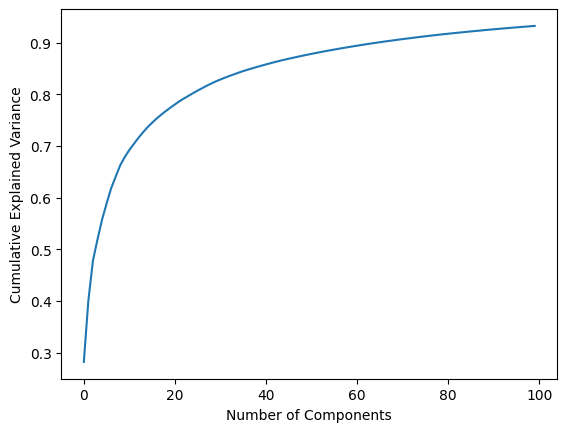

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
pca = PCA(n_components=100)  # Adjust the number based on variance explained
X_train_pca = pca.fit_transform(X_train_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()



# Model Training with SVM

In [ ]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_pca, y_train, test_size=0.2, random_state=42)
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_tr, y_tr)
print("Best Parameters:", grid.best_params_)
svm_model = grid.best_estimator_



Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 9.6min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 5.2min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 6.3min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 5.5min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 5.8min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 6.7min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 6.6min
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time= 6.1min


# Model Evaluation

In [ ]:
y_pred = svm_model.predict(X_val)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))


conf_mat = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


# Prepare Test Data

In [ ]:
X_test = []
im_names = []

test_ims_path = 'test_ims'

for index, row in test_df.iterrows():
    image_path = os.path.join(test_ims_path, row['im_name'])
    img_flat = load_and_preprocess_image(image_path)
    X_test.append(img_flat)
    im_names.append(row['im_name'])

X_test = np.array(X_test)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)


# Make Predictions on Test Data

In [ ]:
test_predictions = svm_model.predict(X_test_pca)


# Additional Tips

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(svm_model, X_train_pca, y_train, cv=5)
print("Cross-validation scores:", scores)
print("Mean cross-validation score:", scores.mean())


# Debug

In [ ]:
print(X_train_pca.shape, y_train.shape)


(8550, 100) (50000,)


In [ ]:
%cd /content/drive/MyDrive/3314 ML/COMP3314_A3/hku-comp3314-2024-1a-a3-image-classification-challenge/train_ims
!ls -1 | wc -l

/content/drive/MyDrive/3314 ML/COMP3314_A3/hku-comp3314-2024-1a-a3-image-classification-challenge/train_ims
8550
